# Firstly load the train and test data and take a final look before making the moves

In [2]:
# load the data
import pandas as pd
train_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/train.csv")
test_df = pd.read_csv("../../cleaned_dataset/split_data/model_selection/test.csv")

In [3]:
train_df.head()

,timestamp,mac address,RSSI,room
0,2023-04-10 14:21:46+09:00,6,-93,kitchen
1,2023-04-10 14:21:46+09:00,6,-93,kitchen
2,2023-04-10 14:21:46+09:00,6,-93,kitchen
3,2023-04-10 14:21:46+09:00,6,-93,kitchen
4,2023-04-10 14:21:46+09:00,6,-93,kitchen


In [4]:
test_df.head()

,timestamp,mac address,RSSI,room
0,2023-04-12 10:00:53+09:00,4,-92,cafeteria
1,2023-04-12 10:00:53+09:00,4,-96,cafeteria
2,2023-04-12 10:00:53+09:00,4,-96,cafeteria
3,2023-04-12 10:00:53+09:00,4,-96,cafeteria
4,2023-04-12 10:00:53+09:00,4,-83,cafeteria


# Starting the pipeline

### Step 1: Feature Engineering Function

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime

def engineer_features(df, window_size='1S'):
    """
    Engineer features from BLE data using time windows.
    
    Parameters:
    - df: DataFrame with columns ['timestamp', 'mac address', 'RSSI', 'room']
    - window_size: Time window for aggregation (default '1S' for 1 second)
    
    Returns:
    - Aggregated DataFrame with 75 features (25 beacons × 3 stats)
    """
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Create window identifier
    df['window'] = df['timestamp'].dt.floor(window_size)
    
    # Initialize feature list
    features_list = []
    
    # Get unique windows
    windows = df['window'].unique()
    
    for window in windows:
        window_data = df[df['window'] == window]
        
        # Get the room label for this window (should be consistent within window)
        room_label = window_data['room'].mode()[0] if len(window_data['room'].mode()) > 0 else window_data['room'].iloc[0]
        
        # Initialize feature dict for this window
        features = {'window': window, 'room': room_label}
        
        # For each of 25 beacons, compute statistics
        for beacon_id in range(1, 26):
            beacon_data = window_data[window_data['mac address'] == beacon_id]
            
            if len(beacon_data) > 0:
                # Mean RSSI
                features[f'beacon_{beacon_id}_mean'] = beacon_data['RSSI'].mean()
                # Standard deviation
                features[f'beacon_{beacon_id}_std'] = beacon_data['RSSI'].std() if len(beacon_data) > 1 else 0
                # Count
                features[f'beacon_{beacon_id}_count'] = len(beacon_data)
            else:
                # Beacon not detected in this window
                features[f'beacon_{beacon_id}_mean'] = 0
                features[f'beacon_{beacon_id}_std'] = 0
                features[f'beacon_{beacon_id}_count'] = 0
        
        features_list.append(features)
    
    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)
    
    print(f"Original records: {len(df)}")
    print(f"Aggregated windows: {len(features_df)}")
    print(f"Features per window: {len(features_df.columns) - 2}")  # Exclude 'window' and 'room'
    
    return features_df

# Engineer features for train and test
print("Engineering features for training set...")
train_features = engineer_features(train_df, window_size='1S')

print("\nEngineering features for test set...")
test_features = engineer_features(test_df, window_size='1S')

print("\nFeature engineering complete!")
print(f"Train set shape: {train_features.shape}")
print(f"Test set shape: {test_features.shape}")

Engineering features for training set...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6128\2309261335.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['window'] = df['timestamp'].dt.floor(window_size)


Original records: 923954
Aggregated windows: 15092
Features per window: 75

Engineering features for test set...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6128\2309261335.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['window'] = df['timestamp'].dt.floor(window_size)


Original records: 145030
Aggregated windows: 5976
Features per window: 75

Feature engineering complete!
Train set shape: (15092, 77)
Test set shape: (5976, 77)


### Step 2: Train XGBoost Model (with unseen class handling)

In [6]:
"""
UPDATED TRAINING CELL - CELL 5
Replace your entire Cell 5 with this code
"""

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pickle
import numpy as np
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE  # <-- NEW IMPORT

# Prepare features and labels
X_train = train_features.drop(columns=['window', 'room'])
y_train = train_features['room']

X_test = test_features.drop(columns=['window', 'room'])
y_test = test_features['room']

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Find classes in train vs test
train_classes = set(label_encoder.classes_)
test_classes = set(y_test.unique())
unseen_classes = test_classes - train_classes

print("="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)
print(f"Classes in train: {len(train_classes)}")
print(f"Classes in test: {len(test_classes)}")
print(f"Unseen classes in test: {len(unseen_classes)}")
if unseen_classes:
    print(f"Unseen class names: {sorted(unseen_classes)}")
print("="*60)

# Filter test set to only include seen classes
test_mask = y_test.isin(train_classes)
X_test_filtered = X_test[test_mask].copy()
y_test_filtered = y_test[test_mask].copy()
test_features_filtered = test_features[test_mask].copy()

print(f"\nOriginal test samples: {len(y_test)}")
print(f"Filtered test samples (seen classes only): {len(y_test_filtered)}")
print(f"Removed samples: {len(y_test) - len(y_test_filtered)}")

# Encode filtered test labels
y_test_encoded = label_encoder.transform(y_test_filtered)

# ============================================================
# NEW CODE: APPLY SMOTE TO BALANCE TRAINING DATA
# ============================================================
print("\n" + "="*60)
print("BEFORE SMOTE - CLASS DISTRIBUTION")
print("="*60)
# Show class distribution before SMOTE
class_dist_before = pd.Series(y_train_encoded).value_counts().sort_index()
for class_idx, count in class_dist_before.items():
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"{class_name:20s}: {count:6d} samples")
print(f"{'TOTAL':20s}: {len(y_train_encoded):6d} samples")

print("\nApplying BorderlineSMOTE to balance classes...")
smote = BorderlineSMOTE(
    sampling_strategy='auto',  # Balance all classes
    k_neighbors=5,
    random_state=42
)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_encoded)

print("\n" + "="*60)
print("AFTER SMOTE - CLASS DISTRIBUTION")
print("="*60)
class_dist_after = pd.Series(y_train_balanced).value_counts().sort_index()
for class_idx, count in class_dist_after.items():
    class_name = label_encoder.inverse_transform([class_idx])[0]
    before_count = class_dist_before.get(class_idx, 0)
    increase = count - before_count
    print(f"{class_name:20s}: {count:6d} samples (+{increase:5d})")
print(f"{'TOTAL':20s}: {len(y_train_balanced):6d} samples")
print("="*60)
# ============================================================

print(f"\nNumber of classes in model: {len(label_encoder.classes_)}")
print(f"Training samples after SMOTE: {len(X_train_balanced)}")

# Train XGBoost
print("\nTraining XGBoost model...")
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# Train on BALANCED data (no sample weights needed anymore!)
model.fit(X_train_balanced, y_train_balanced)

print("Training complete!")

# Save model, label encoder, and metadata
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save metadata
metadata = {
    'train_classes': list(train_classes),
    'test_classes': list(test_classes),
    'unseen_classes': list(unseen_classes),
    'n_train_samples_original': len(X_train),
    'n_train_samples_after_smote': len(X_train_balanced),
    'n_test_samples_original': len(y_test),
    'n_test_samples_filtered': len(y_test_filtered)
}
with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("Model, label encoder, and metadata saved!")

# Store for next cells
globals()['X_test_eval'] = X_test_filtered
globals()['y_test_eval'] = y_test_filtered
globals()['y_test_eval_encoded'] = y_test_encoded
globals()['test_features_filtered'] = test_features_filtered
globals()['unseen_classes'] = unseen_classes

CLASS DISTRIBUTION ANALYSIS
Classes in train: 18
Classes in test: 19
Unseen classes in test: 3
Unseen class names: ['503', '505', '515']

Original test samples: 5976
Filtered test samples (seen classes only): 5889
Removed samples: 87

BEFORE SMOTE - CLASS DISTRIBUTION
501                 :     50 samples
502                 :      9 samples
506                 :     65 samples
508                 :     17 samples
511                 :     96 samples
512                 :    159 samples
513                 :     15 samples
516                 :     23 samples
517                 :     15 samples
518                 :      5 samples
520                 :     70 samples
522                 :    181 samples
523                 :    232 samples
cafeteria           :   3320 samples
cleaning            :    108 samples
hallway             :    620 samples
kitchen             :   2885 samples
nurse station       :   7222 samples
TOTAL               :  15092 samples

Applying BorderlineSMOTE to

### Step 3: Evaluate on Test Set

In [7]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Predict on filtered test set
y_pred_encoded = model.predict(X_test_eval)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Calculate Macro F1 Score
macro_f1 = f1_score(y_test_eval_encoded, y_pred_encoded, average='macro')

# Calculate per-class F1 scores
per_class_f1 = f1_score(y_test_eval_encoded, y_pred_encoded, average=None)

print("="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)
print(f"\n🎯 Macro F1 Score: {macro_f1:.4f}")
print(f"\n⚠️  Note: Evaluation excludes {len(y_test) - len(y_test_eval)} samples")
print(f"   from {len(unseen_classes)} unseen class(es): {sorted(unseen_classes)}")
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test_eval, y_pred, digits=4))

# Per-class F1 scores
print("\n" + "="*60)
print("PER-CLASS F1 SCORES")
print("="*60)
class_f1_dict = dict(zip(label_encoder.classes_, per_class_f1))
for room, f1 in sorted(class_f1_dict.items(), key=lambda x: x[1]):
    print(f"{room:20s}: {f1:.4f}")

# Save results to file
with open('model_evaluation_results.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("MODEL EVALUATION RESULTS\n")
    f.write("="*60 + "\n")
    f.write(f"\nMacro F1 Score: {macro_f1:.4f}\n")
    f.write(f"\nNote: Evaluation excludes {len(y_test) - len(y_test_eval)} samples\n")
    f.write(f"from {len(unseen_classes)} unseen class(es): {sorted(unseen_classes)}\n")
    f.write("\n" + "="*60 + "\n")
    f.write("CLASSIFICATION REPORT\n")
    f.write("="*60 + "\n")
    f.write(classification_report(y_test_eval, y_pred, digits=4))
    f.write("\n" + "="*60 + "\n")
    f.write("PER-CLASS F1 SCORES\n")
    f.write("="*60 + "\n")
    for room, f1 in sorted(class_f1_dict.items(), key=lambda x: x[1]):
        f.write(f"{room:20s}: {f1:.4f}\n")
    f.write("\n" + "="*60 + "\n")
    f.write("CONFUSION MATRIX\n")
    f.write("="*60 + "\n")
    f.write(str(confusion_matrix(y_test_eval, y_pred)))
    f.write("\n")

print("\n✅ Results saved to: model_evaluation_results.txt")

MODEL EVALUATION RESULTS

🎯 Macro F1 Score: 0.2244

⚠️  Note: Evaluation excludes 87 samples
   from 3 unseen class(es): ['503', '505', '515']

CLASSIFICATION REPORT
               precision    recall  f1-score   support

          501     0.1319    0.8000    0.2264        15
          502     0.8000    0.0580    0.1081        69
          506     0.0000    0.0000    0.0000        97
          508     0.0000    0.0000    0.0000         0
          511     0.1029    0.1522    0.1228        46
          512     0.6522    0.1128    0.1923       133
          513     0.7308    0.1056    0.1845       180
          516     0.0000    0.0000    0.0000         0
          517     0.0000    0.0000    0.0000         2
          518     0.0000    0.0000    0.0000        13
          520     0.6333    0.5000    0.5588       190
          522     0.1129    0.4118    0.1772        17
          523     0.4316    0.7455    0.5467       110
    cafeteria     0.3908    0.3526    0.3707      1248
     cle

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

### Step 4: Generate Predictions for Original Test Records

In [8]:
# Assign predictions to original TEST records only (frame-level)
print("Assigning predictions to original test records...")

# Convert timestamp in original test_df (this is already test set only)
test_df_copy = test_df.copy()
test_df_copy['timestamp'] = pd.to_datetime(test_df_copy['timestamp'])
test_df_copy['window'] = test_df_copy['timestamp'].dt.floor('1S')

# Create mapping from window to predicted room (only for filtered windows)
window_predictions = dict(zip(test_features_filtered['window'], y_pred))

# Assign predictions to each test record based on its window
test_df_copy['predicted_room'] = test_df_copy['window'].map(window_predictions)

# Mark records from unseen classes
if len(unseen_classes) > 0:
    unseen_mask = test_df_copy['room'].isin(unseen_classes)
    test_df_copy.loc[unseen_mask, 'predicted_room'] = 'UNKNOWN_CLASS'

# Fill any remaining NaN (shouldn't happen but just in case)
test_df_copy['predicted_room'] = test_df_copy['predicted_room'].fillna('UNKNOWN')

# Save predictions (test set only)
predictions_df = test_df_copy[['timestamp', 'room', 'predicted_room']].copy()
predictions_df.to_csv('test_predictions.csv', index=False)

print(f"✅ Predictions assigned to {len(predictions_df)} TEST records")
print(f"   - {len(predictions_df[predictions_df['predicted_room'] != 'UNKNOWN_CLASS'])} records with predictions")
if len(unseen_classes) > 0:
    print(f"   - {len(predictions_df[predictions_df['predicted_room'] == 'UNKNOWN_CLASS'])} records from unseen classes")
print(f"\n✅ Predictions saved to: test_predictions.csv")

# Show sample predictions
print("\nSample predictions (seen classes):")
print(predictions_df[predictions_df['predicted_room'] != 'UNKNOWN_CLASS'].head(10))

if len(unseen_classes) > 0:
    print("\nSample predictions (unseen classes):")
    print(predictions_df[predictions_df['predicted_room'] == 'UNKNOWN_CLASS'].head(5))

Assigning predictions to original test records...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6128\1829811279.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  test_df_copy['window'] = test_df_copy['timestamp'].dt.floor('1S')


✅ Predictions assigned to 145030 TEST records
   - 141425 records with predictions
   - 3605 records from unseen classes

✅ Predictions saved to: test_predictions.csv

Sample predictions (seen classes):
                  timestamp       room predicted_room
0 2023-04-12 10:00:53+09:00  cafeteria      cafeteria
1 2023-04-12 10:00:53+09:00  cafeteria      cafeteria
2 2023-04-12 10:00:53+09:00  cafeteria      cafeteria
3 2023-04-12 10:00:53+09:00  cafeteria      cafeteria
4 2023-04-12 10:00:53+09:00  cafeteria      cafeteria
5 2023-04-12 10:00:53+09:00  cafeteria      cafeteria
6 2023-04-12 10:00:53+09:00  cafeteria      cafeteria
7 2023-04-12 10:00:53+09:00  cafeteria      cafeteria
8 2023-04-12 10:00:53+09:00  cafeteria      cafeteria
9 2023-04-12 10:00:53+09:00  cafeteria      cafeteria

Sample predictions (unseen classes):
                      timestamp room predicted_room
53780 2023-04-12 11:05:08+09:00  515  UNKNOWN_CLASS
53781 2023-04-12 11:05:08+09:00  515  UNKNOWN_CLASS
53782 202

### Step 5: Calculate performance statistics for frame - level - actual metrics here

In [9]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

print("="*60)
print("FRAME-LEVEL EVALUATION (True Performance)")
print("="*60)

# Get ground truth and predictions at frame level
y_true_frame = predictions_df['room']
y_pred_frame = predictions_df['predicted_room']

# Filter out UNKNOWN_CLASS for fair evaluation (same as window-level)
known_mask = y_pred_frame != 'UNKNOWN_CLASS'
y_true_frame_filtered = y_true_frame[known_mask]
y_pred_frame_filtered = y_pred_frame[known_mask]

print(f"\nTotal test frames: {len(predictions_df)}")
print(f"Frames with predictions: {len(y_true_frame_filtered)}")
print(f"Frames from unseen classes: {len(predictions_df) - len(y_true_frame_filtered)}")

# Calculate Macro F1 Score (frame-level)
macro_f1_frame = f1_score(y_true_frame_filtered, y_pred_frame_filtered, average='macro')

# Calculate Accuracy
accuracy_frame = accuracy_score(y_true_frame_filtered, y_pred_frame_filtered)

print("\n" + "="*60)
print("FRAME-LEVEL METRICS")
print("="*60)
print(f"🎯 Macro F1 Score (Frame-level): {macro_f1_frame:.4f}")
print(f"📊 Accuracy (Frame-level): {accuracy_frame:.4f}")

print("\n" + "="*60)
print("FRAME-LEVEL CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true_frame_filtered, y_pred_frame_filtered, digits=4))

# Per-class F1 scores at frame level
per_class_f1_frame = f1_score(y_true_frame_filtered, y_pred_frame_filtered, average=None, labels=sorted(y_true_frame_filtered.unique()))
print("\n" + "="*60)
print("PER-CLASS F1 SCORES (Frame-level)")
print("="*60)
class_f1_dict_frame = dict(zip(sorted(y_true_frame_filtered.unique()), per_class_f1_frame))
for room, f1 in sorted(class_f1_dict_frame.items(), key=lambda x: x[1]):
    print(f"{room:20s}: {f1:.4f}")

# Compare window-level vs frame-level
print("\n" + "="*60)
print("COMPARISON: Window-level vs Frame-level")
print("="*60)
print(f"Window-level Macro F1: {macro_f1:.4f}")
print(f"Frame-level Macro F1:  {macro_f1_frame:.4f}")
print(f"Difference:            {abs(macro_f1 - macro_f1_frame):.4f}")

# Save frame-level results
with open('frame_level_evaluation_results.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("FRAME-LEVEL EVALUATION RESULTS\n")
    f.write("="*60 + "\n")
    f.write(f"\nTotal test frames: {len(predictions_df)}\n")
    f.write(f"Frames with predictions: {len(y_true_frame_filtered)}\n")
    f.write(f"Frames from unseen classes: {len(predictions_df) - len(y_true_frame_filtered)}\n")
    f.write(f"\nMacro F1 Score (Frame-level): {macro_f1_frame:.4f}\n")
    f.write(f"Accuracy (Frame-level): {accuracy_frame:.4f}\n")
    f.write("\n" + "="*60 + "\n")
    f.write("FRAME-LEVEL CLASSIFICATION REPORT\n")
    f.write("="*60 + "\n")
    f.write(classification_report(y_true_frame_filtered, y_pred_frame_filtered, digits=4))
    f.write("\n" + "="*60 + "\n")
    f.write("PER-CLASS F1 SCORES (Frame-level)\n")
    f.write("="*60 + "\n")
    for room, f1 in sorted(class_f1_dict_frame.items(), key=lambda x: x[1]):
        f.write(f"{room:20s}: {f1:.4f}\n")
    f.write("\n" + "="*60 + "\n")
    f.write("COMPARISON: Window-level vs Frame-level\n")
    f.write("="*60 + "\n")
    f.write(f"Window-level Macro F1: {macro_f1:.4f}\n")
    f.write(f"Frame-level Macro F1:  {macro_f1_frame:.4f}\n")
    f.write(f"Difference:            {abs(macro_f1 - macro_f1_frame):.4f}\n")
    f.write("\n" + "="*60 + "\n")
    f.write("CONFUSION MATRIX (Frame-level)\n")
    f.write("="*60 + "\n")
    f.write(str(confusion_matrix(y_true_frame_filtered, y_pred_frame_filtered)))
    f.write("\n")

print("\n✅ Frame-level results saved to: frame_level_evaluation_results.txt")

FRAME-LEVEL EVALUATION (True Performance)

Total test frames: 145030
Frames with predictions: 141425
Frames from unseen classes: 3605

FRAME-LEVEL METRICS
🎯 Macro F1 Score (Frame-level): 0.2386
📊 Accuracy (Frame-level): 0.4668

FRAME-LEVEL CLASSIFICATION REPORT


c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

               precision    recall  f1-score   support

          501     0.0964    0.6513    0.1679       628
          502     0.4456    0.0958    0.1578      1325
          506     0.0000    0.0000    0.0000       883
          508     0.0000    0.0000    0.0000         0
          511     0.2218    0.1293    0.1634      2042
          512     0.8138    0.0900    0.1620      5635
          513     0.8573    0.1226    0.2146     12932
          516     0.0000    0.0000    0.0000         0
          517     0.0000    0.0000    0.0000        42
          518     0.0000    0.0000    0.0000       180
          520     0.7741    0.4567    0.5745      6125
          522     0.1293    0.2236    0.1639       917
          523     0.6086    0.7992    0.6910      8484
    cafeteria     0.4971    0.3619    0.4189     25229
     cleaning     0.4695    0.2800    0.3508     10817
      hallway     0.0121    0.0493    0.0194      3612
      kitchen     0.6188    0.6479    0.6330     28076
nurse sta

c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 


✅ Frame-level results saved to: frame_level_evaluation_results.txt


c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Step 6: Heatmap for easier observation of where is the model be triggered

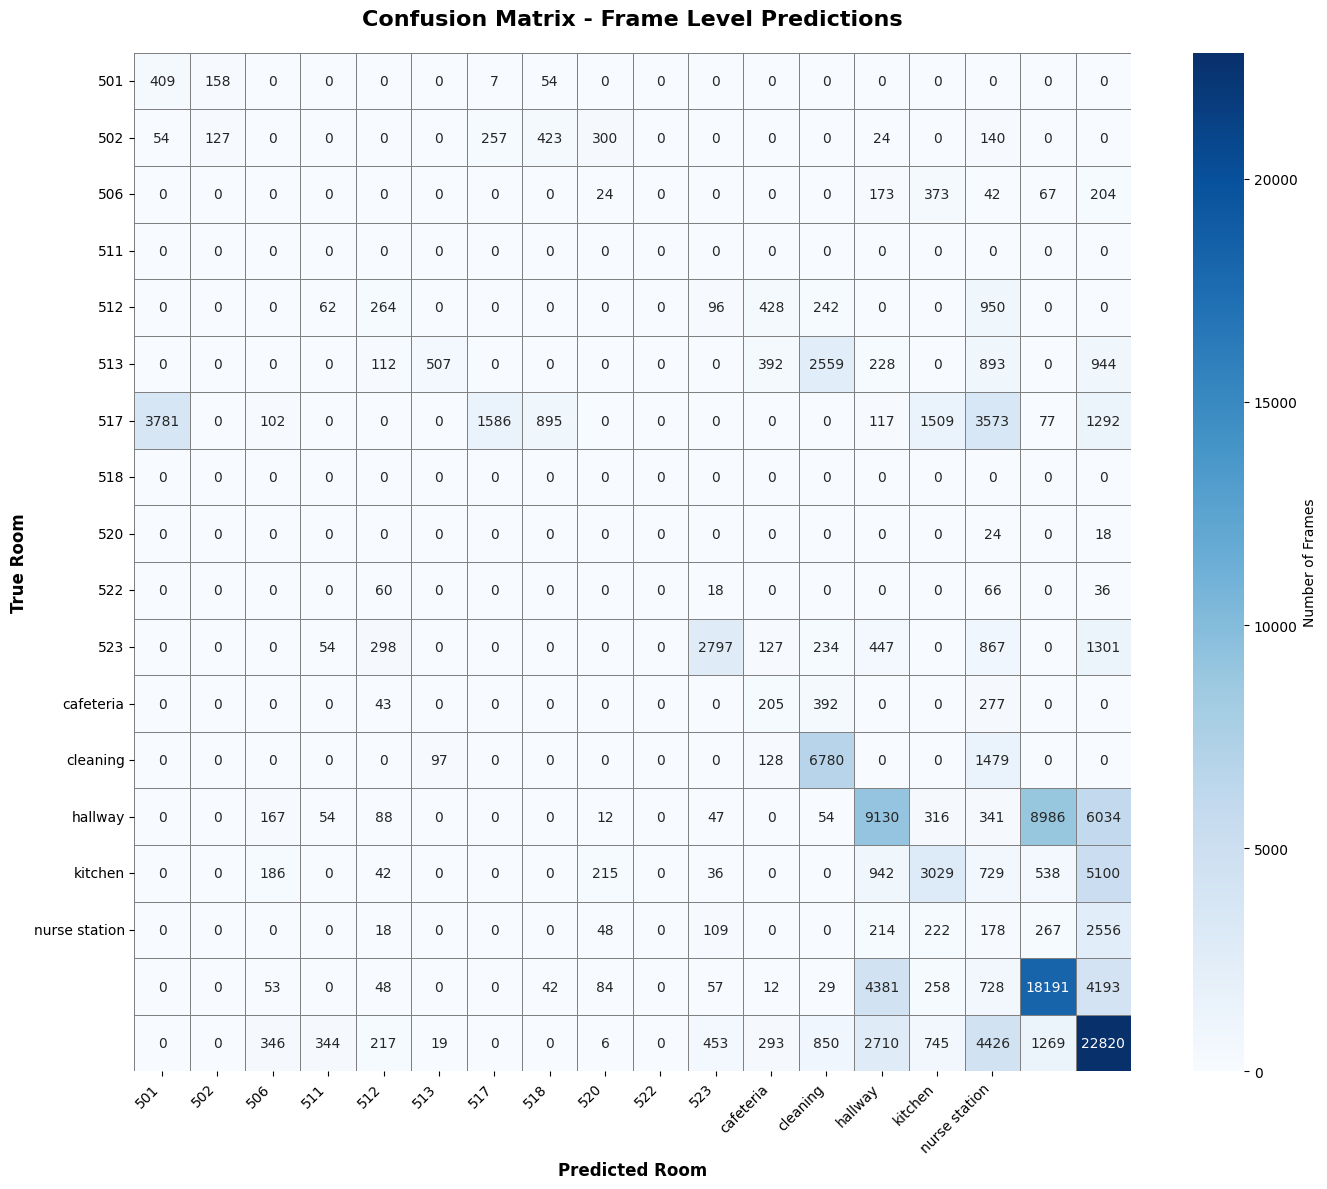

✅ Confusion matrix heatmap saved to: confusion_matrix_frame_level.png

CONFUSION MATRIX ANALYSIS - Top Misclassifications

Top 15 Misclassifications (by count):
------------------------------------------------------------
 1. 517             → 501             |   3781 frames (29.24% of 517)
 2. 517             → nurse station   |   3573 frames (27.63% of 517)
 3. 513             → cleaning        |   2559 frames (45.41% of 513)
 4. 517             → kitchen         |   1509 frames (11.67% of 517)
 5. cleaning        → nurse station   |   1479 frames (17.43% of cleaning)
 6. 512             → nurse station   |    950 frames (46.52% of 512)
 7. kitchen         → hallway         |    942 frames ( 8.71% of kitchen)
 8. 517             → 518             |    895 frames ( 6.92% of 517)
 9. 513             → nurse station   |    893 frames (15.85% of 513)
10. 523             → nurse station   |    867 frames (14.16% of 523)
11. kitchen         → nurse station   |    729 frames ( 6.74% of kitc

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6128\1456718163.py:38: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


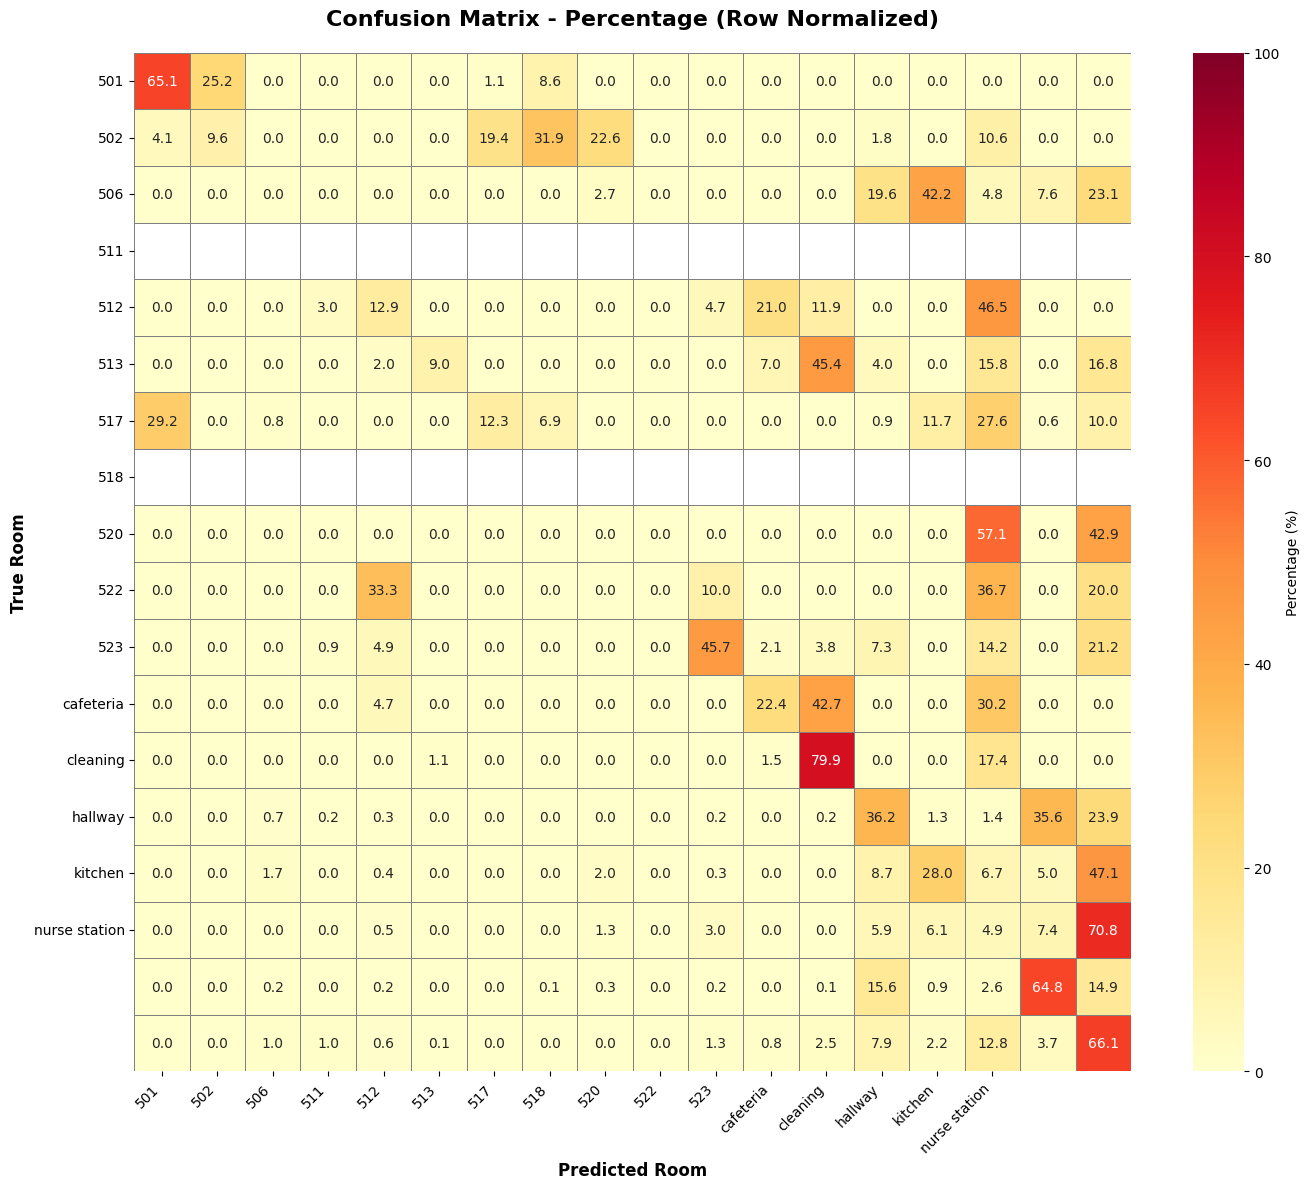


✅ Percentage confusion matrix saved to: confusion_matrix_percentage_frame_level.png


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(y_true_frame_filtered, y_pred_frame_filtered)
classes = sorted(y_true_frame_filtered.unique())

# Create figure
plt.figure(figsize=(14, 12))

# Plot heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Number of Frames'},
            linewidths=0.5, linecolor='gray')

plt.title('Confusion Matrix - Frame Level Predictions', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Room', fontsize=12, fontweight='bold')
plt.ylabel('True Room', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save figure
plt.savefig('confusion_matrix_frame_level.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix heatmap saved to: confusion_matrix_frame_level.png")

# Calculate and display percentage confusion matrix
print("\n" + "="*60)
print("CONFUSION MATRIX ANALYSIS - Top Misclassifications")
print("="*60)

# Convert to percentage (row-wise normalization)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Find top misclassifications
misclassifications = []
for i, true_class in enumerate(classes):
    for j, pred_class in enumerate(classes):
        if i != j:  # Not diagonal (not correct predictions)
            count = cm[i, j]
            percent = cm_percent[i, j]
            if count > 0:  # Only include actual misclassifications
                misclassifications.append({
                    'true': true_class,
                    'predicted': pred_class,
                    'count': count,
                    'percent': percent
                })

# Sort by count (most frequent misclassifications first)
misclassifications_sorted = sorted(misclassifications, key=lambda x: x['count'], reverse=True)

print("\nTop 15 Misclassifications (by count):")
print("-" * 60)
for idx, mis in enumerate(misclassifications_sorted[:15], 1):
    print(f"{idx:2d}. {mis['true']:15s} → {mis['predicted']:15s} | "
          f"{mis['count']:6d} frames ({mis['percent']:5.2f}% of {mis['true']})")

# Create percentage heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='YlOrRd',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage (%)'},
            linewidths=0.5, linecolor='gray',
            vmin=0, vmax=100)

plt.title('Confusion Matrix - Percentage (Row Normalized)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Room', fontsize=12, fontweight='bold')
plt.ylabel('True Room', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save percentage figure
plt.savefig('confusion_matrix_percentage_frame_level.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Percentage confusion matrix saved to: confusion_matrix_percentage_frame_level.png")